**线性回归的从零开始实现**

为了简单起⻅，我们将根据带有噪声的线性模型构造⼀个⼈造数据集。我们的任务是使⽤这个有限样本的数据集来恢复这个模型的参数。我们将使⽤低维数据，这样可以很容易地将其可视化。在下⾯的代码中，我们⽣成⼀个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成X
    y = torch.matmul(X, w) + b  # 生成y
    y += torch.normal(0, 0.01, y.shape)  # 加上噪声
    return X, y.reshape((-1, 1))

In [11]:
true_w = torch.tensor([2, -3.4])  # 真实权重
true_b = 4.2  # 真实偏差
features, labels = synthetic_data(true_w, true_b, 1000)  # 生成数据集

print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.4392, -0.2983]) 
label: tensor([4.3277])


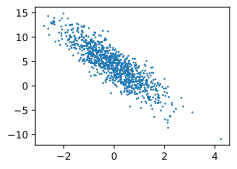

In [12]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);  # 画图

**读取数据集**

回想⼀下，训练模型时要对数据集进⾏遍历，每次抽取⼀⼩批量样本，并使⽤它们来更新我们的模型。由于
这个过程是训练机器学习算法的基础，所以有必要定义⼀个函数，该函数能打乱数据集中的样本并以⼩批量
⽅式获取数据。
在下⾯的代码中，我们定义⼀个data_iter函数，该函数接收批量⼤⼩、特征矩阵和标签向量作为输⼊，⽣成
⼤⼩为batch_size的⼩批量。每个⼩批量包含⼀组特征和标签。

In [13]:
def data_iter(batch_size, features, labels):  #@save
    """Iterate through a dataset."""
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 随机读取小批量
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])  # 最后一次可能不足一个batch
        yield features[batch_indices], labels[batch_indices]

In [14]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7836,  0.3081],
        [ 0.1144,  1.3549],
        [ 0.3188, -0.0361],
        [-1.0805,  0.7697],
        [ 0.0368,  2.2901],
        [-0.4786,  0.6221],
        [ 0.1356, -2.4798],
        [ 1.1318, -0.4096],
        [ 0.1337,  0.7042],
        [ 1.9411,  0.7399]]) 
 tensor([[ 4.7113],
        [-0.1814],
        [ 4.9706],
        [-0.5755],
        [-3.5251],
        [ 1.1312],
        [12.9018],
        [ 7.8644],
        [ 2.0899],
        [ 5.5804]])


In [15]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)  # 初始化模型参数
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):  #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size  # 更新参数
            param.grad.zero_()

**训练**

- 初始化参数
- 重复以下训练，直到完成
    - 计算梯度
    - 更新参数

In [16]:
lr = 0.03  # 学习率
num_epochs = 3  # 迭代次数
net = linreg  # 线性回归模型
loss = squared_loss  # 损失函数

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 计算损失
        l.sum().backward()  # 求和后反向传播
        sgd([w, b], lr, batch_size)  # 更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)  # 计算训练损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037186
epoch 2, loss 0.000148
epoch 3, loss 0.000054


因为我们使⽤的是⾃⼰合成的数据集，所以我们知道真正的参数是什么。因此，我们可以通过⽐较真实参数和通过训练学到的参数来评估训练的成功程度。事实上，真实参数和通过训练学到的参数确实⾮常接近。

In [17]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([5.3895e-04, 2.3127e-05], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0005], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。在机器学习中，我们通常不太关⼼恢复真正的参数，⽽更关⼼如何⾼度准确预测参数。幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到⾮常好的解。其中⼀个原因是，在深度⽹络中存在许多参数组合能够实现⾼度精确的预测。

**使用深度学习框架来实现线性回归**

In [18]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])  # 真实权重
true_b = 4.2  # 真实偏差
features, labels = d2l.synthetic_data(true_w, true_b, 1000)  # 生成数据集

In [19]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)  # 将数据集打包
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [20]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)  # 读取数据

next(iter(data_iter))

[tensor([[ 0.3788,  0.4779],
         [ 1.6194,  0.5844],
         [-2.2994,  0.9389],
         [-1.3064,  0.0689],
         [-0.7167, -3.1137],
         [ 1.4439,  1.0800],
         [-1.4299, -0.9296],
         [ 0.0825, -0.5076],
         [-0.3130,  0.0458],
         [ 0.5167,  0.3329]]),
 tensor([[ 3.3385],
         [ 5.4577],
         [-3.5969],
         [ 1.3644],
         [13.3458],
         [ 3.4115],
         [ 4.4933],
         [ 6.0726],
         [ 3.4138],
         [ 4.1202]])]

In [21]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))  # 线性回归模型

net[0].weight.data.normal_(0, 0.01)  # 初始化权重
net[0].bias.data.fill_(0)  # 初始化偏差

tensor([0.])

In [22]:
# 损失函数
loss = nn.MSELoss()

# 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [23]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        trainer.zero_grad()  # 梯度清零
        l = loss(net(X), y)
        l.backward()  # 反向传播
        trainer.step()  # 更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000180
epoch 2, loss 0.000102
epoch 3, loss 0.000102


In [24]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-6.0272e-04,  7.6056e-05])
error in estimating b: tensor([0.0005])


## softmax回归

**独热编码（one-hot embedding）**

**图像分类数据集**

In [25]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中。

In [26]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100%|██████████| 26421880/26421880 [00:07<00:00, 3549290.30it/s]


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 120010.59it/s]


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1482799.46it/s]


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 35646.29it/s]


Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [27]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [28]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤⼦）、pullover（套衫）、dress（连⾐
裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以
下函数⽤于在数字标签索引及其⽂本名称之间进⾏转换。

In [29]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)  # 创建子图
    axes = axes.flatten()  # 将子图展开成一维
    for i, (ax, img) in enumerate(zip(axes, imgs)):  # 画图
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)  # 不显示坐标轴
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

以下是训练数据集中前⼏个样本的图像及其相应的标签。

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

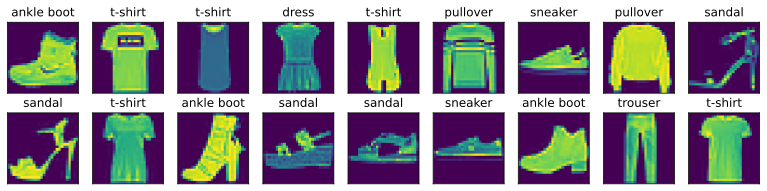

In [30]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [31]:
# 读取小批量
batch_size = 256

def get_dataloader_workers():  #@save
    import sys
    """Use 4 processes to read the data except for Windows."""
    return 0 if sys.platform.startswith('win') else 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [32]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'5.98 sec'

In [33]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)  # 将多个变换组合起来
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                                num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                                num_workers=get_dataloader_workers()))

In [34]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


**softmax回归的从零开始实现**

In [35]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [36]:
# 初始化模型参数

num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [37]:
# 定义softmax操作
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [38]:
def softmax(X): 
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [39]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0647, 0.3796, 0.4020, 0.1021, 0.0517],
         [0.0417, 0.2375, 0.2998, 0.3109, 0.1100]]),
 tensor([1.0000, 1.0000]))

In [40]:
# 定义模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [41]:
# 定义损失函数
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [42]:
def cross_entropy(y_hat, y): 
    """Cross entropy loss."""
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [43]:
def accuracy(y_hat, y): #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: 
        y_hat = y_hat.argmax(axis=1) 
    cmp = y_hat.type(y.dtype) == y 
    return float(cmp.type(y.dtype).sum())

In [44]:
accuracy(y_hat, y) / len(y)

0.5

In [45]:
def evaluate_accuracy(net, data_iter): #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module): 
        net.eval() # 设置为评估模式
    metric = Accumulator(2) # 正确预测数，预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [46]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args): 
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self): 
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx): 
        return self.data[idx]

In [47]:
evaluate_accuracy(net, test_iter)

0.0803

In [48]:
# 训练
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """The training loop defined in Chapter 3."""
    # Set the model in training mode
    if isinstance(net, torch.nn.Module): 
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer): 
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel())
        else: 
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [49]:
class Animator: #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None: 
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: 
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"): 
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): 
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None: 
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [50]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [51]:
lr = 0.1

def updater(batch_size): 
    return d2l.sgd([W, b], lr, batch_size)

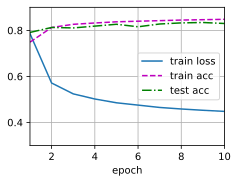

In [52]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

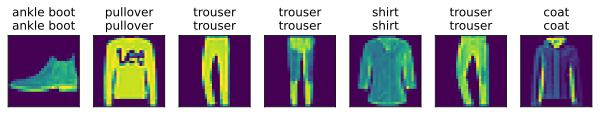

In [56]:
# 预测
def predict_ch3(net, test_iter, n=7): #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)

softmax回归的简洁实现

In [57]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [58]:
# PyTorch不会隐式地调整输入的形状。因此，我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [59]:
loss = nn.CrossEntropyLoss(reduction='none')

In [60]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

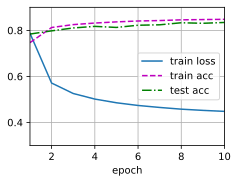

In [61]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

**激活函数**

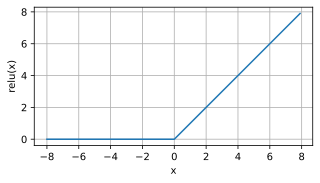

In [64]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

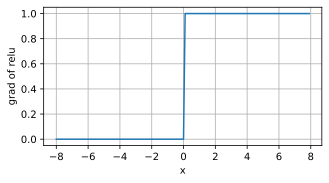

In [65]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

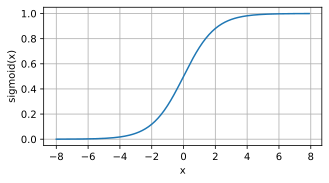

In [66]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

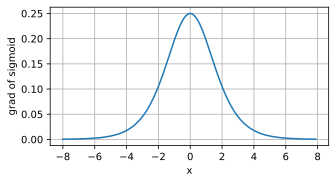

In [67]:
# 清除以前的梯度
x.grad.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

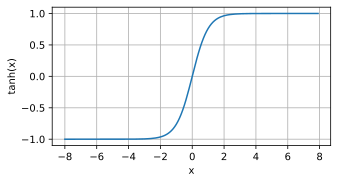

In [68]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

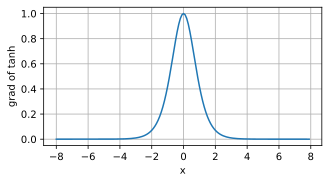

In [69]:
# 清除以前的梯度
x.grad.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))